# Hamiltonian energy level shoveling demo

In [1]:
import numpy as np
from scipy.linalg import expm
import lindbladian_sim as lbs
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)

## Construct a random Hamiltonian

In [3]:
# system size
d = 40

In [4]:
# random Hamiltonian
H = lbs.crandn((d, d), rng)
H = 0.5 * (H + H.conj().T)

In [5]:
eigvals, eigvec = np.linalg.eigh(H)

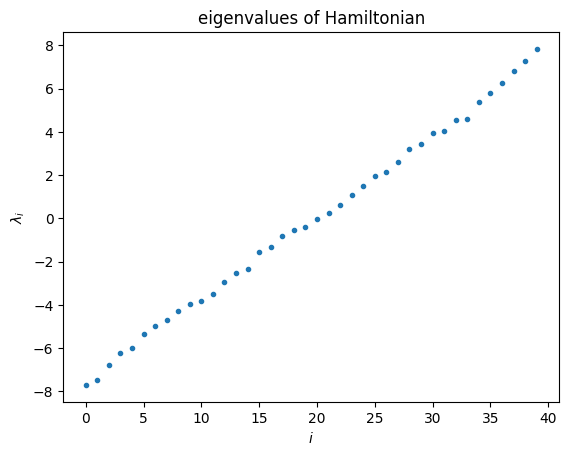

In [6]:
plt.plot(eigvals, '.')
plt.xlabel(r"$i$")
plt.ylabel(r"$\lambda_i$")
plt.title("eigenvalues of Hamiltonian")
plt.show()

In [7]:
# spectral gap
gap = eigvals[1] - eigvals[0]
print("eigenvalue gap:", gap)

eigenvalue gap: 0.2480333447726073


## Filter function

In [8]:
# spectral width
Sw = np.linalg.norm(H, ord=2)
Sw

7.834562242804822

In [9]:
# parameters for filter function
a  = 2.5*Sw
da = 0.5*Sw
b  = gap
db = gap

fhat = lambda w: lbs.filter_function(w, a, da, b, db)

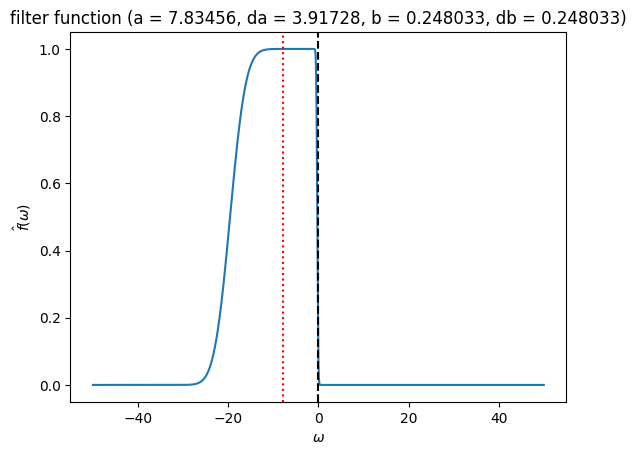

In [10]:
# visualize filter function
wlist = np.linspace(-50, 50, 1001, endpoint=True)
plt.plot(wlist, fhat(wlist))
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\hat{f}(\omega)$")
plt.title(f"filter function (a = {Sw:g}, da = {da:g}, b = {b:g}, db = {db:g})")
plt.axvline(0, color="k", linestyle="--")
plt.axvline(-Sw, color="r", linestyle=":")
plt.show()

## Construct Lindblad operator

In [11]:
# "sparse" local operator
A = np.kron(lbs.crandn((d//5, d//5), rng), np.identity(5))

In [12]:
# shoveling Lindblad jump operator
K = lbs.construct_shoveling_lindblad_operator(A, H, fhat)
K.shape

(40, 40)

## Simulate dissipative time evolution

In [13]:
# time step
tau = 0.1

In [14]:
# time evolution operator (superoperator representation), including coherent Hamiltonian part
expHK = expm(tau * (lbs.hamiltonian_superoperator(H) + lbs.lindblad_operator_matrix(K)))
expHK.shape

(1600, 1600)

In [15]:
# time evolution operator (superoperator representation), without coherent Hamiltonian part
expK = expm(tau * lbs.lindblad_operator_matrix(K))
expK.shape

(1600, 1600)

In [16]:
rho_init = lbs.random_density_matrix(d, rng)

In [17]:
nsteps = 2000

rho = rho_init
en_list = [np.trace(H @ rho).real]
for n in range(nsteps):
    rho = np.reshape(expHK @ rho.reshape(-1), rho.shape)
    en_list.append(np.trace(H @ rho).real)

# without coherent Hamiltonian part
rho = rho_init
en_list_bare = [np.trace(H @ rho).real]
for n in range(nsteps):
    rho = np.reshape(expK @ rho.reshape(-1), rho.shape)
    en_list_bare.append(np.trace(H @ rho).real)

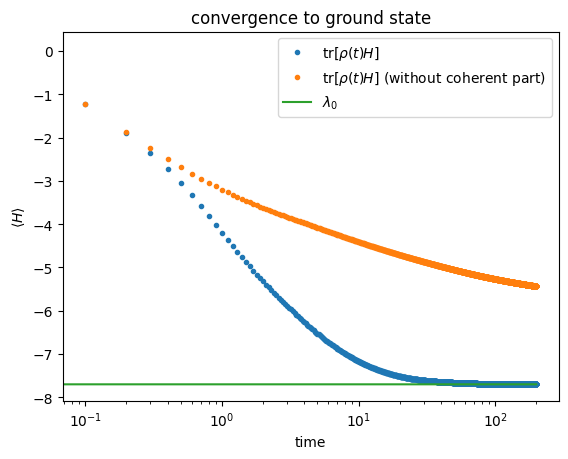

In [18]:
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), en_list_bare, ".", label=r"$\mathrm{tr}[\rho(t) H]$ (without coherent part)")
plt.semilogx(tau * np.arange(nsteps + 1), eigvals[0]*np.ones(nsteps + 1), label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()

## Eigenvalues of Lindbladian superoperator

In [19]:
# including coherent Hamiltonian part
eigHK = sorted(np.linalg.eigvals(lbs.hamiltonian_superoperator(H) + lbs.lindblad_operator_matrix(K)), key=lambda z: z.real)
eigHK[-10:]

[(-0.10332024826452167-1.7171367028519267j),
 (-0.10332024826451493+1.7171367028519255j),
 (-0.1024529869575937+0.7570906307732815j),
 (-0.10245298695758637-0.7570906307732892j),
 (-0.08683369910714665+1.0198613195870811j),
 (-0.08683369910714629-1.0198613195870783j),
 (-0.03162410695077411-6.71829578006959e-15j),
 (-0.01694198525864307+0.26274392350140446j),
 (-0.016941985258639887-0.2627439235014119j),
 (-8.298310879681383e-14+4.96436688784656e-14j)]

In [20]:
# without coherent Hamiltonian part
eigK = sorted(np.linalg.eigvals(lbs.lindblad_operator_matrix(K)), key=lambda z: z.real)
eigK[-10:]

[(-5.941824483366284e-09+6.894293863759773e-17j),
 (-5.29021310243817e-13-6.120452902485439e-17j),
 (-3.9775454852019367e-13-4.868382403918137e-17j),
 (-3.975216484829628e-13+9.57624870740872e-17j),
 (-3.9729631085837957e-13+3.878613596241404e-16j),
 (-3.965754131657219e-13+1.31816306807701e-16j),
 (-5.348341337190974e-16+4.2298781920907617e-16j),
 (-5.288896050481407e-16-3.6264215395252645e-18j),
 (6.289610642226461e-17+2.1209114584857842e-16j),
 (1.311338283948676e-15-6.516436410542748e-16j)]

In [21]:
# observing several eigenvalues which are numerically 0, i.e., stationary state is not unique
np.abs(eigK[-10:])

array([5.94182448e-09, 5.29021314e-13, 3.97754551e-13, 3.97521660e-13,
       3.97296500e-13, 3.96575435e-13, 6.81884335e-16, 5.28902037e-16,
       2.21220646e-16, 1.46432494e-15])